신경망 학습의 절차
전제: 신경망에는 적응 가능한 가중치와 편향이 있고, 이 가중치와 편향을 훈련데이터에 적응하도록 조정하는 과정을 '학습'이라한다. 
1단계-미니배치
훈련 데이터 중 일부를 무작위로 가져온다. 이렇게 선별한 데이터를 미니배치라 하며, 그 미니배치의 손실 함수 값을 줄이는 것이 목표다
2단계 기울기 산출
미니배치의 손실 함수 값을 줄이기 위해 각 가중치 매개변수의 기울기를 구한다. 기울기는 손실함수의 값을 가장 작게하는 방향을 제시한다.
3단계-매개변수 갱신
가중치 매개변수를 기울기 방향으로 아주 조금 갱신한다.
4단계-반복
1~3단계를 반복한다.
경사 하강법으로 매개변수를 갱신하는 방법이며, 이때 데이터를 미니배치로 무작위로 선정하기 때문에 확률적 경사 하강법이라 부른다. '확률적으로 무작위로 골라낸 데이터'에 대해 수행하는 경사 하강법이라는 의미이다.


In [3]:
# coding: utf-8
import numpy as np
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.functions import *
from common.gradient import numerical_gradient

def sigmoid(x):
    return 1 / (1 + np.exp(-x))   

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

def softmax(x):
    if x.ndim == 2:#x배열이 2차원이라면
        x = x.T
        x = x - np.max(x, axis=0)#np배열에서 가장큰 x를 구해서 x에 모든 수를 뻄
        y = np.exp(x) / np.sum(np.exp(x), axis=0)#y에 소프트맥스함수를 적용해서 구함
        return y.T #T가 뭐지?

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))
    
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
#딕셔너리로 params변수를 설정하며 모든 변수들을 초기화함.

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']#각변수에 값을 넣음
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1#x는 이미지데이터로 추론함
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):#손실함수
        y = self.predict(x)
        
        return cross_entropy_error(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])#정확도를 구함 모든 수를 더하고 x의 크기만큼 나눔
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads


train acc, test acc | 0.10218333333333333, 0.101
train acc, test acc | 0.7946333333333333, 0.7978
train acc, test acc | 0.8767166666666667, 0.881
train acc, test acc | 0.8988166666666667, 0.9021
train acc, test acc | 0.90855, 0.9099
train acc, test acc | 0.9148833333333334, 0.9164
train acc, test acc | 0.9194333333333333, 0.9214
train acc, test acc | 0.9245, 0.924
train acc, test acc | 0.9277333333333333, 0.9278
train acc, test acc | 0.9318833333333333, 0.932
train acc, test acc | 0.93445, 0.9356
train acc, test acc | 0.9376, 0.9393
train acc, test acc | 0.9396333333333333, 0.9389
train acc, test acc | 0.94165, 0.9406
train acc, test acc | 0.9441666666666667, 0.9438
train acc, test acc | 0.9458833333333333, 0.9448
train acc, test acc | 0.9476166666666667, 0.9453


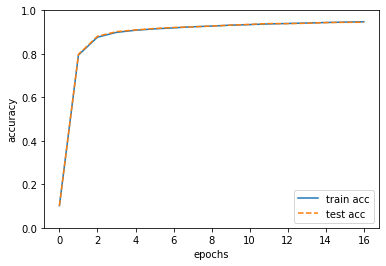

In [4]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1 #학습률

train_loss_list = []#훈련데이터의 손실함수값
train_acc_list = []#훈련 데이터의 정확도 값
test_acc_list = []#정답 레이블의 정확도 값

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


미니배치 크기를 100으로 하고 60000개의 훈련 데이터에서 임의로 데이터를 추려냅니다.(이미지데이터와 정답레이블 데이터)그리고 그 100개의 미니배치를 대상으로 확률적 경사하강법을 수행해 매개변수를 갱신합니다. 이 횟수를 10000번으로 설정해 변화추이를 그래프로 볼수 있습니다.
그래프를 보면 학습횟수가 늘어나면서 손실 함수의 값이 줄어드는 것을 볼 수 있다.
이는 학습이 잘 되는것으로 판단할 수 있다.
손실함수의 값이 작아지는 것은 학습이 잘 된다는 것으로 판단할 수 있지만 훈련 데이터외의 데이터를 올바르게 인식하는지를 확인해야한다. 다른 말로 오버피팅을 일으키지 않는지 확인해야한다. 오버피팅은 훈련데이터에 포함된 이미지만 제대로 구분하고 그렇지 않은 이미지는 식별할 수 없다는 뜻이다.
신경망 학습의 원래 목표는 범용적인 능력을 익히는 것이다. 범용 능력을 평가하려면 훈련 데이터에 포함되지 않은 데이터를 사용해 평가해봐야한다.


5. 오차역전파법->기울기를 효율적으로 계산하는 방법
1-수식
2-계산 그래프

5.1 계산그래프
계산과정을 그래프로 나타낸 것
그래프->그래프 자료구조로, 복수의 노드와에지로 표현된다.(에지: 노드사이의 직선)
1.계산그래프를 구성한다.
2.그래프에서 계산을 왼쪽에서 오른쪽순으로 진행한다.(순전파)->반대방향으로진행(역전파)

계산 그래프의 특징: 국소적 계산->결과얻음.(국소적->자신과 직접 관계된 작은 범위)
국소적 계산은 결국 전체에서 어떤 일이 벌어지든 상관없이 자신과 관계된 정보만으로 결과를 출력할 수 있다는 것이다.->아무리 복잡해도 단순한 계산에 집중해 문제 단순화가능or 중간 결과를 모두 보관할 수 있음.

계산그래프를 쓰는이유->역전파를 통해 '미분'을 효율적으로 계산할 수 있다.


5.2 연쇄법칙
국소적 미분(역순)을 전달하는 원리는 연쇄법칙에 따른다.
역전파의 계산 절차는 신호E에 노드의 국소적 미분을 곱한 후 다음 노드로 전달하는 것이다. 국소적 미분은 순전파 때의 y=f(x)계산 미분을 구한다는 것이며, x에 대한 y의 미분을 구한다는 뜻이다.

연쇄법칙이란?
합성 함수의 미분에 대한 성질.
합성함수의 미분은 합성 함수를 구성하는 각 함수의 미분의 곱으로 나타낼 수 있다.

각각의 편미분을 곱한 것이 연쇄법칙의 미분

5.3 역전파

덧셈 노드의 역전파->z=x+y
이 식을 대상으로 역전파를 살펴보면 z=x+y의 미분으로
x로의 미분과 y로의 미분으로 나눌 수 있따. 이러한 미분값은 모두 1이다.
그래서 역전파 때는 상류에서 전해진 미분에 1을 곱하여 하류로 흘린다.

곱셈 노드의 역전파->z=xy
x로의 미분=y, y로의 미분은 x이다.
곱셈 노드의 역전파는 상류에서 입력 신호들을 서로바꾼 값을 곱해 하류로 보낸다.

5.4
forward()순전파 처리
backword()->역전파 처리

In [ ]:
# coding: utf-8


class MulLayer:
    def __init__(self):#초기화
        self.x = None
        self.y = None

    def forward(self, x, y):
        self.x = x
        self.y = y                
        out = x * y

        return out

    def backward(self, dout):
        dx = dout * self.y  # x와 y를 바꾼다.
        dy = dout * self.x

        return dx, dy


class AddLayer:
    def __init__(self):
        pass

    def forward(self, x, y):
        out = x + y

        return out

    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1

        return dx, dy


In [ ]:
# coding: utf-8
from layer_naive import *


apple = 100
apple_num = 2
tax = 1.1

mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

# backward
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print("price:", int(price))
print("dApple:", dapple)
print("dApple_num:", int(dapple_num))
print("dTax:", dtax)


In [ ]:
# coding: utf-8
from layer_naive import *

apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# layer
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)  # (1)
orange_price = mul_orange_layer.forward(orange, orange_num)  # (2)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)  # (3)
price = mul_tax_layer.forward(all_price, tax)  # (4)

# backward
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)  # (4)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)  # (3)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)  # (2)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)  # (1)

print("price:", int(price))
print("dApple:", dapple)
print("dApple_num:", int(dapple_num))
print("dOrange:", dorange)
print("dOrange_num:", int(dorange_num))
print("dTax:", dtax)
